<a href="https://colab.research.google.com/github/GingerSpacetail/family-heritage/blob/main/MB_Data_analysis_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimental and Syntetic data


## Preparation

### Import libraries

In [1]:
#%pip install latexify-py #run for the first time only or conda install at your machine

In [2]:
#%pip install xlsxwriter #run for the first time only or conda install at your machine

In [3]:
import statsmodels.stats.power as smp
from statsmodels.stats.power import TTestIndPower

import numpy as np
from numpy import array
from numpy import std, mean, sqrt

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot

import plotly.express as px
import plotly.graph_objects as go

import scipy as sp
import scipy.optimize
import scipy.stats
from scipy.optimize import curve_fit

import latexify
import xlsxwriter

import seaborn as sns

#from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.activations import relu,linear
#from tensorflow.keras.losses import SparseCategoricalCrossentropy
#from tensorflow.keras.optimizers import Adam

#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [4]:
#!pip install fitter #to choose the best distribution

In [5]:
#!pip install scipy # install SciPy


## Explore your dataset

### Import your data

Upload data from your computer or mount your google drive

In [39]:

data = pd.read_excel('RFU values for Giulia modified 2.xlsx', sheet_name='Sheet1', header=[0,1], index_col=0)

Have a look at what has been imported (optional)

In [40]:
data

Time (min)     Brain                          Lung                      \
Time (min) unknown 1 unknown 2 unknown 3 unknown 1 unknown 2 unknown 3   
10             39585     41747     39776     38394     39978     39407   
60             36579     35295     39343     28980     29200     28189   
180            31008     33687     32117     18615     18416     19153   
360            21891     21953     26086     13513     13084     11447   
1200           12789     12420     13546      5029      4878      5081   

Time (min)     Liver                      
Time (min) unknown 1 unknown 2 unknown 3  
10             37513     37801     37047  
60             28393     29076     29318  
180            18181     18674     13645  
360            12971     12290     13543  
1200            4347      4434      4505

Make an array of cell line names from your column names (e.g.treated vs untreated, human vs model, different organs or tissues etc.)

In [41]:
cell_line_names = np.array(data.columns.levels[0])
cell_line_names

array(['Brain', 'Liver', 'Lung'], dtype=object)

The cell below make simple arithmetics for plotting (painful)

In [42]:
for i in cell_line_names:
  data[i,'median'] = data[i].median(axis=1)
  data[i,'max'] = data[i].max(axis=1)
  data[i,'min'] = data[i].min(axis=1)
  data[i,'SD'] = data[i].std(axis=1) #standard deviation in measuarements for each time point
  data[i,'err+'] = data[i]['max'] - data[i]['median']
  data[i,'err-'] = data[i]['median'] - data[i]['min']
  data = data.sort_index(axis=1)

Have a look at the new dataset

In [43]:
data

Time (min)        Brain                                                       \
Time (min)           SD    err+    err-      max   median      min unknown 1   
10          1070.549143  1971.0   191.0  41747.0  39776.0  39585.0     39585   
60          1850.212817  2764.0  1284.0  39343.0  36579.0  35295.0     36579   
180         1203.983499  1570.0  1109.0  33687.0  32117.0  31008.0     31008   
360         2150.459114  4133.0    62.0  26086.0  21953.0  21891.0     21891   
1200         513.431073   757.0   369.0  13546.0  12789.0  12420.0     12789   

Time (min)                            Liver  ...                  Lung         \
Time (min) unknown 2 unknown 3           SD  ... unknown 3          SD   err+   
10             41747     39776   340.316715  ...     37047  717.520360  571.0   
60             35295     39343   429.057572  ...     29318  475.563105  220.0   
180            33687     32117  2479.494196  ...     13645  341.020820  538.0   
360            21953     26086   561.064940  ...     13543  975.169455  429.0   
1200           12420     13546    70.780412  ...      4505   94.314368   52.0   

Time (min)                                                                   
Time (min)    err-      max   median      min unknown 1 unknown 2 unknown 3  
10          1013.0  39978.0  39407.0  38394.0     38394     39978     39407  
60           791.0  29200.0  28980.0  28189.0     28980     29200     28189  
180          199.0  19153.0  18615.0  18416.0     18615     18416     19153  
360         1637.0  13513.0  13084.0  11447.0     13513     13084     11447  
1200         151.0   5081.0   5029.0   4878.0      5029      4878      5081  

[5 rows x 27 columns]

### Descriptive statistics

#### Sample size, mean, standard deviation

In [45]:
for i in cell_line_names:
  print(data[i,'median'].describe())


count        5.000000
mean     28642.800000
std      11125.397485
min      12789.000000
25%      21953.000000
50%      32117.000000
75%      36579.000000
max      39776.000000
Name: (Brain, median), dtype: float64
count        5.000000
mean     20435.000000
std      13068.557476
min       4434.000000
25%      12971.000000
50%      18181.000000
75%      29076.000000
max      37513.000000
Name: (Liver, median), dtype: float64
count        5.000000
mean     21023.000000
std      13471.446897
min       5029.000000
25%      13084.000000
50%      18615.000000
75%      28980.000000
max      39407.000000
Name: (Lung, median), dtype: float64


### Explore the data with some plots



Extract x axis from indexes of your dataset

In [46]:
x_values = np.asarray(data.index/60).reshape(-1,1)
x_values #in hours

array([[ 0.16666667],
       [ 1.        ],
       [ 3.        ],
       [ 6.        ],
       [20.        ]])

#### Errorbar plot

In [47]:
fig = go.Figure()


#this loop goes through all cell lines and plot
for i in cell_line_names:
  fig.add_trace(go.Scatter(
      name=i,
      x=x_values[:, 0],
      y=data[i,'median'],
      mode='markers', # not connected points, place a '#' before the line if you would like to plot connected points
      error_y=dict(
          type='data',
          symmetric=False,
          array=data[i,'err+'],
          arrayminus=data[i,'err-'])
      ))

fig.update_layout(
    title='Avidin Binding Over Time',
    autosize=True, #or Fausle if you would like to set your size of the plot
#    height = 500,
#    width = 1000,
#    margin=dict(r=20, b=10, l=10, t=30),
    scene=dict(
        xaxis_title='Time (hrs)',
        yaxis_title='Avidin binding (relative RFU x 10^4)'
        )
    )

fig.show()

#### Violin plot (if more that 3 data point)
to see means, quantiles and develop intuition about difference btw samples

In [48]:
#this loop goes through all cell lines and plot
for i in cell_line_names:
  plot = go.Figure()
  plot.add_trace(go.Violin(x=data.index,
                           y=data.loc[:,pd.IndexSlice[i, ('max','median','min')]],
                           line_color=px.colors.qualitative.Plotly[list(cell_line_names).index(i)],
                           name=i))
  plot.update_layout(violinmode='group')
  plot.show()

In [49]:

#this loop goes through all cell lines and plot
for i in cell_line_names:
  fig = px.violin(
      data.loc[:,pd.IndexSlice[i, :]],
      y = ('max','median','min'),
      title= i,
      box=True,
      points='all')
  fig.show()




In [50]:
data.loc[:,pd.IndexSlice[i, ('max','median','min')]].droplevel(level=0, axis=1)

Time (min),max,median,min
10,39978.0,39407.0,38394.0
60,29200.0,28980.0,28189.0
180,19153.0,18615.0,18416.0
360,13513.0,13084.0,11447.0
1200,5081.0,5029.0,4878.0


#### Histogam (the more datapoint the better)
to have a look at the distribution (looks better with more samples)

In [51]:
for i in cell_line_names:
  fig = px.histogram(
      data.loc[:,pd.IndexSlice[i, ('max','median','min')]].droplevel(level=0, axis=1),
      x='median',
      nbins=20,
      title = i)
  fig.show()

### Distribution
We will fit the best distribution and check stat assumptions for statisticak tests:

normality and homoscedasticity

#### Example on generated data

In [52]:
from scipy import stats
synthetic_data = stats.gamma.rvs(3, loc=1.5, scale=2, size=1000)

In [53]:
#the list of all distributions avalible for test
from fitter import get_distributions
get_distributions()

['_fit',
 'alpha',
 'anglit',
 'arcsine',
 'argus',
 'beta',
 'betaprime',
 'bradford',
 'burr',
 'burr12',
 'cauchy',
 'chi',
 'chi2',
 'cosine',
 'crystalball',
 'dgamma',
 'dweibull',
 'erlang',
 'expon',
 'exponnorm',
 'exponpow',
 'exponweib',
 'f',
 'fatiguelife',
 'fisk',
 'foldcauchy',
 'foldnorm',
 'gamma',
 'gausshyper',
 'genexpon',
 'genextreme',
 'gengamma',
 'genhalflogistic',
 'genhyperbolic',
 'geninvgauss',
 'genlogistic',
 'gennorm',
 'genpareto',
 'gibrat',
 'gompertz',
 'gumbel_l',
 'gumbel_r',
 'halfcauchy',
 'halfgennorm',
 'halflogistic',
 'halfnorm',
 'hypsecant',
 'invgamma',
 'invgauss',
 'invweibull',
 'jf_skew_t',
 'johnsonsb',
 'johnsonsu',
 'kappa3',
 'kappa4',
 'ksone',
 'kstwo',
 'kstwobign',
 'laplace',
 'laplace_asymmetric',
 'levy',
 'levy_l',
 'levy_stable',
 'loggamma',
 'logistic',
 'loglaplace',
 'lognorm',
 'loguniform',
 'lomax',
 'maxwell',
 'mielke',
 'moyal',
 'multivariate_normal',
 'nakagami',
 'ncf',
 'nct',
 'ncx2',
 'norm',
 'norminvgaus

In [54]:
#get sub set of common distributions
from fitter import get_common_distributions
get_common_distributions()

['cauchy',
 'chi2',
 'expon',
 'exponpow',
 'gamma',
 'lognorm',
 'norm',
 'powerlaw',
 'rayleigh',
 'uniform']

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.016754,840.598816,-10976.156621,inf,0.015071,0.974448
chi2,0.016754,840.598299,-10976.151641,inf,0.015074,0.974402
lognorm,0.018159,830.092186,-10895.593658,inf,0.021072,0.757967
rayleigh,0.023678,941.881234,-10637.167940,inf,0.055665,0.003911
exponpow,0.043590,935.752672,-10019.953648,inf,0.065704,0.000338


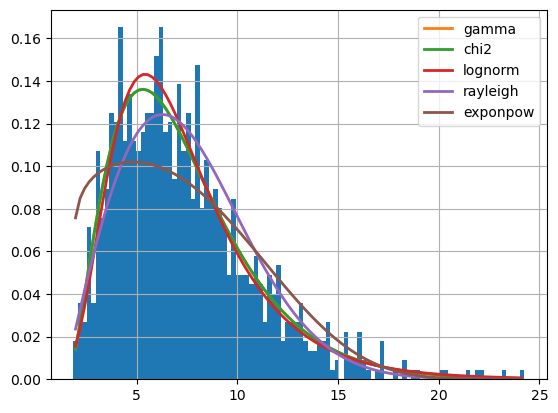

In [55]:
import fitter
f = fitter.Fitter(synthetic_data)

# just a trick to use only 10 distributions instead of 80 to speed up the fitting
#f.distributions = f.distributions[0:10] + ['gamma']

# another trick to use only common distributions instead of 80 to speed up the fitting
f.distributions = get_common_distributions()

# fit and plot
f.fit()
f.summary()
# may take some time since by default

In [56]:
#Return best fitted distribution and its parameters
#a dictionary with one key (the distribution name) and its parameters

f.get_best(method='sumsquare_error')

{'gamma': {'a': 2.847912297582135,
  'loc': 1.491164241514848,
  'scale': 2.0615194304566833}}

#### Find distribution of our actual data

In [23]:
#f = fitter.Fitter(data['Bain','median'],
#                  distributions = get_common_distributions())

# we'll use only common distributions instead of 80 to speed up the fitting


# fit and plot
#f.fit()
#f.summary()
# may take some time


### Modelling on the data

#### Functions to fit

In [57]:
# This is the model function, e.g., an exponential decay
def model(x, a, b):
    return a * np.exp(-b * x)

#shifted exponential decay
def exp_func(x, a, b):
    return a * np.exp(-b * x)

#shifted squared exponential decay
def exp_squared_func(x, a, b, c):
    return a * np.exp(-b * x*x) + c

#linear function
def linear_func(x, a, b):
    return a*x + b


Have a look at the functions in a more convenient way

In [58]:
@latexify.function
def model_show(x, a, b):
    return a * e**(-b * x)

model_show # Displays the expression.

In [59]:
@latexify.function
def exp_func_show(x, a, b, c):
    return a * e**(-b * x) + c

exp_func_show # Displays the expression.


In [60]:
@latexify.function
def exp_squared_func_show(x, a, b, c):
    return a * e**(-b * x**2) + c

exp_squared_func_show


In [61]:
@latexify.function

def linear_func_show(x, a, b):
    return a*x + b

linear_func_show

Prepare empty dataframes for coeffients and covariance matrices to store fitted parameters

In [62]:
coeffs = pd.DataFrame(0, index=['a','b'], columns=cell_line_names)

In [63]:
coeffs

,Brain,Liver,Lung
a,0,0,0
b,0,0,0


In [64]:
covar_matrices = {}
for i in cell_line_names:
  covar_matrices[i]=np.zeros([2,2])


In [65]:
covar_matrices

{'Brain': array([[0., 0.],
        [0., 0.]]),
 'Liver': array([[0., 0.],
        [0., 0.]]),
 'Lung': array([[0., 0.],
        [0., 0.]])}

#### Fitting your data

In [66]:
# Perform the curve fitting with exp function
for i in cell_line_names:
  params, covar = curve_fit(model, x_values[:, 0], data[i,'median'], sigma=data[i,'SD'], absolute_sigma=True)
  coeffs[i]=params
  covar_matrices[i]=covar

#### Estimate the errors of the fitting

In [69]:
from sklearn.metrics import r2_score

for i in cell_line_names:
  data[i, 'Fitted y data'] = model(x_values[:, 0], *coeffs[i])
  data[i, 'r2_score = Goodness of fit'] = r2_score(data[i, 'median'], data[i, 'Fitted y data']) #a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. In other words, r-squared shows how well the data fit the regression model (the goodness of fit)
  data = data.sort_index(axis=1)

In [70]:
data

Time (min)         Brain                                                 \
Time (min) Fitted y data           SD    err+    err-      max   median   
10          38569.317541  1070.549143  1971.0   191.0  41747.0  39776.0   
60          36788.913081  1850.212817  2764.0  1284.0  39343.0  36579.0   
180         32844.069539  1203.983499  1570.0  1109.0  33687.0  32117.0   
360         27705.562507  2150.459114  4133.0    62.0  26086.0  21953.0   
1200        12524.114071   513.431073   757.0   369.0  13546.0  12789.0   

Time (min)                                                          ...  \
Time (min)      min r2_score = Goodness of fit unknown 1 unknown 2  ...   
10          39585.0                   0.928921     39585     41747  ...   
60          35295.0                   0.928921     36579     35295  ...   
180         31008.0                   0.928921     31008     33687  ...   
360         21891.0                   0.928921     21891     21953  ...   
1200        12420.0                   0.928921     12789     12420  ...   

Time (min)        Lung                                            \
Time (min)          SD   err+    err-      max   median      min   
10          717.520360  571.0  1013.0  39978.0  39407.0  38394.0   
60          475.563105  220.0   791.0  29200.0  28980.0  28189.0   
180         341.020820  538.0   199.0  19153.0  18615.0  18416.0   
360         975.169455  429.0  1637.0  13513.0  13084.0  11447.0   
1200         94.314368   52.0   151.0   5081.0   5029.0   4878.0   

Time (min)                                                           
Time (min) r2_score = Goodness of fit unknown 1 unknown 2 unknown 3  
10                           0.813967     38394     39978     39407  
60                           0.813967     28980     29200     28189  
180                          0.813967     18615     18416     19153  
360                          0.813967     13513     13084     11447  
1200                         0.813967      5029      4878      5081  

[5 rows x 33 columns]

### Save file

Save to xlsx file and download it

In [71]:
## save to xlsx file
writer = pd.ExcelWriter('Data analysis.xlsx', engine='xlsxwriter')
data.to_excel(writer, 'Sheet1')
writer.save()

/var/folders/q6/lfkm7xkn3h11bnq166v52624wtdt_h/T/ipykernel_55501/443755655.py:3: FutureWarning:

Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.



AttributeError: 'XlsxWriter' object has no attribute 'save'

Coefficients of the fitted function

In [72]:
coeffs

,Brain,Liver,Lung
a,38935.607377,35595.248053,29997.698170
b,0.056713,0.105889,0.091773


In [73]:
covar_matrices

{'Brain': array([[6.85388475e+05, 1.10342051e+00],
        [1.10342051e+00, 5.75872216e-06]]),
 'Liver': array([[7.94492057e+04, 1.29407480e-01],
        [1.29407480e-01, 8.72341130e-07]]),
 'Lung': array([[1.15459706e+05, 2.49657276e-01],
        [2.49657276e-01, 1.46165184e-06]])}

### Plotting the data with the fitted curves

#### Choose your coloscheme

In [74]:
px.colors.qualitative.swatches()

In [75]:
px.colors.qualitative.Vivid


['rgb(229, 134, 6)',
 'rgb(93, 105, 177)',
 'rgb(82, 188, 163)',
 'rgb(153, 201, 69)',
 'rgb(204, 97, 176)',
 'rgb(36, 121, 108)',
 'rgb(218, 165, 27)',
 'rgb(47, 138, 196)',
 'rgb(118, 78, 159)',
 'rgb(237, 100, 90)',
 'rgb(165, 170, 153)']

#### Plott the data and fitted curves

In [76]:
fig = go.Figure()

trace_list = []
for i in cell_line_names:
  trace_measured = go.Scatter(
      name=i,
      x=x_values[:, 0],
      y=data[i,'median'],
      mode='markers', # not connected points, place a '#' before the line if you would like to plot connected points
      error_y=dict(
          type='data',
          symmetric=False,
          array=data[i,'err+'],
          arrayminus=data[i,'err-']),
      marker = dict(
          size = 4,
          color=px.colors.qualitative.Plotly[list(cell_line_names).index(i)]) #we are using Plotly colorscheme, you may change it to Prism or Vivid at your preferences
      )
  trace_fitted = go.Scatter(
      name='Fitted {cell_line} curve'.format(cell_line = i),
      x=x_values[:, 0],
      y=model(np.linspace(min(x_values[:, 0]), max(x_values[:, 0])*1.1, 50), *coeffs[i]), #fitted curve with 50 points between min and 110% of max values of the original x values
      mode = 'lines',
      line = dict(
          color =px.colors.qualitative.Plotly[list(cell_line_names).index(i)], #we are using Plotly colorscheme and fitted curve matches the measured color
          width = 2,
          dash = 'dot')
      )

  trace_list.append(trace_measured)
  trace_list.append(trace_fitted)

fig.add_traces(trace_list)

fig.update_layout(
    title='Avidin Binding Over Time',
    xaxis_title="Time (hrs)",
    yaxis_title="Avidin binding (relative RFU)",
    legend_title="Cell types",
    autosize=True, #or Fausle if you would like to set your size of the plot
#    height = 500,
#    width = 1000,
#    margin=dict(r=20, b=10, l=10, t=30),

    )

fig.show()

#### A piece of machine learning

In [77]:
from sklearn.base import RegressorMixin


class NullRegressor(RegressorMixin):
  def fit(self, X=None, y=None):
        # The prediction will always just be the mean of y
        self.y_bar_ = np.mean(y)

  def predict(self, X=None):
        # Give back the mean of y, in the same
        # length as the number of X observations
        return np.ones(X.shape[0]) * self.y_bar_

The format to use one

```
model = YourCustomModel()
model.fit(X, y)
model.predict(X)
```



In [78]:
X = x_values #Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
y = data['Brain','median']
y = y.values.reshape(-1,1)

model = NullRegressor()
model.fit(X, y)
model.predict(X)


array([28642.8, 28642.8, 28642.8, 28642.8, 28642.8])

In [79]:
r2_score(y, model.predict(X)) #(the goodness of fit) a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. In other words, r-squared shows how well the data fit the regression model

0.0

We can access the following output

```
    .fit()
    .predict()
    .score()
    .set_params()
    .get_params()```



ValueError: x and y must be the same size

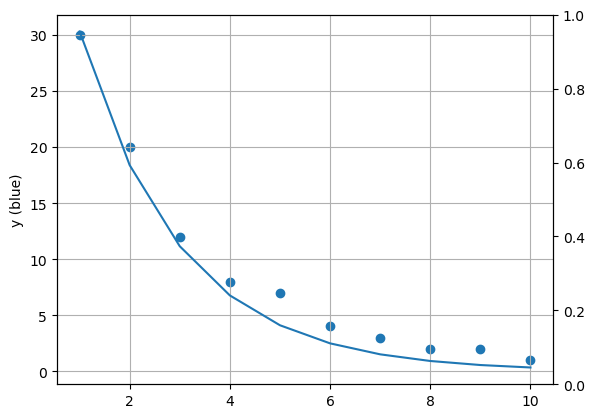

In [80]:
from scipy.stats import expon

x = np.linspace(1, 10, 10)
y_r = np.array([30, 20, 12, 8, 7, 4, 3, 2, 2, 1])
y_fit = expon.pdf(x, scale=2)*100

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y_r)
ax.plot(x, y_fit)
ax.set_ylabel('y (blue)')
ax.grid(True)

ax2 = ax.twinx()
ax2.scatter(x, np.log(y), color='red')
ax2.set_ylabel('log(y) (red)')

plt.show()

In [81]:
X.shape

(5, 1)

In [82]:
y.shape

(5, 1)

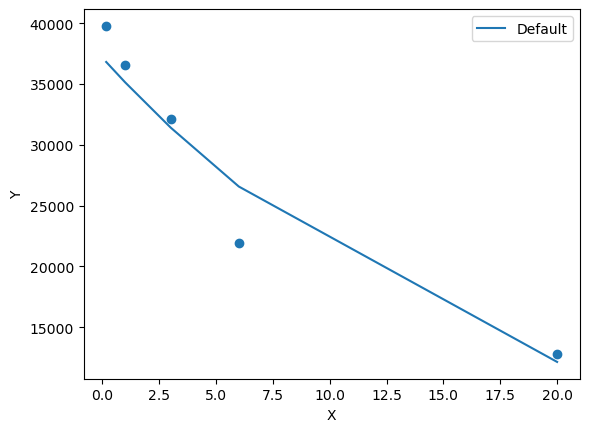

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate

ln_y = np.log(y)


# X.shape should be (N, M) where M >= 1

# y.shape should be (N, 1)
# perform label encoding if "label" contains strings
# y = pd.factorize(mydata['label'])[0].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Use the relation ln(Y) = ln(A) - BX to fit X to ln(Y)
from sklearn.linear_model import LinearRegression
model_exp_reg = LinearRegression()
model_exp_reg.fit(X, ln_y)

#### We can introduce weights as well to apply more bias to the smaller X values,
#model_exp_reg_weighted = LinearRegression()
#model_exp_reg_weighted.fit(X, ln_y, sample_weight=np.array(1/((X - 100).values**2)).reshape(-1)) #apply higher arbitrary weights to smaller X values

### Get predicted values of Y
Y_pred = np.exp(model_exp_reg.predict(X))
#Y_pred_weighted = np.exp(model_exp_reg_weighted.predict(X))

### Plot
plt.scatter(X, y)
plt.plot(X, Y_pred, label='Default')
#plt.plot(X, Y_pred_weighted, label='Weighted')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

In [84]:
model_exp_reg.score(X, y)
model_exp_reg.get_params(X, y)

TypeError: BaseEstimator.get_params() takes from 1 to 2 positional arguments but 3 were given

## Example on a publicly available dataset

In [ ]:
#pip install nhanes #do this if you would like to run the code on real word data

In [ ]:
#from nhanes.load import load_NHANES_data

In [ ]:
#np.random.seed(12345)

#nhanes_data = load_NHANES_data()
#adult_nhanes_data = nhanes_data.query('AgeInYearsAtScreening > 18')
#adult_nhanes_data = adult_nhanes_data.dropna(subset=['WeightKg']).rename(columns={'WeightKg': 'Weight'})
#sample_1 = adult_nhanes_data['Weight'].values
#sample_2 = sample_1 - mean(sample_1)

Let's have a mean of our samples

In [ ]:
#print(mean(sample_1))
#print(mean(sample_2))

## Example on dummy data

In [ ]:
#dummy data
#sample_1 = [2,4,7,3,7,35,8,9]
#sample_2 = [i*2 for i in sample_1]
# extra element so that two group sizes are not equal.
#sample_2.append(10)

## Power analysis

In [ ]:
f = fitter.Fitter(dataset['LIVER TRIGLY'].values,
                  distributions = get_common_distributions())

# we'll use only common distributions instead of 80 to speed up the fitting


# fit and plot
f.fit()
f.summary()
# may take some time




In [ ]:
f.get_best(method='sumsquare_error')
#Return best fitted distribution and its parameters

In [ ]:
f = fitter.Fitter(dataset[dataset['DIET] == "HFD")].values,
                      distributions = get_common_distributions()) # we'll use only common distributions instead of 80 to speed up the fitting
f.fit() # fit and plot
f.summary()

Statistical Power calculations for t-test for two independent sample

### Calculate reliminary parameters¶

We can compute a power analysis using functions from the statsmodels.stats.power package.

The goal to determine a difference in the mean between two groups using an independent samples t-test.

Let’s calculate an effect size of Cohen’s d
$$ d = \frac {(M_2 - M_1)} {SD_{pooled}} $$
where $M_i$ is mean for an $i$-th sample,

and $SD_{pooled}$ is a pooled standard deviation $$SDpooled = \sqrt{\frac{(n_1 - 1) * SD_1^2 + (n_2 - 1) * SD_2^2} {n_1 + n_2 - 2}}$$  


Cohen’s D , or standardized mean difference, is one of the most common ways to measure effect size. An effect size is how large an effect is. For example, medication A has a larger effect than medication B. While a p-value can tell you if there is an effect, it won’t tell you how large that effect is.

Cohen’s D specifically measures the effect size of the difference between two means

![Cohen's distance: source statisticshowto.com](https://scientificallysoundorg360.files.wordpress.com/2017/07/cohen_example-e1499923427851.png?w=860)

In [ ]:
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)


In [ ]:
d_12 = cohen_d(sample_1, sample_2)
print(d_12)

### Calculate the sample size

We wish to have 80% power to find the effect if it exists. We can compute the sample size needed for adequate power using the TTestIndPower() function:

In [ ]:
power_analysis = smp.TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=d_12, power=0.8, alpha=0.05)
sample_size

In [ ]:
output = "We need {size:.0f} obesrvations to detect difference in our data"
print(output.format(size = sample_size))

## General observations on power, sample size, and significance

A plot showing how many samples we need to achieve the desired power of the test with the given statistical significance $\alpha$. It's nice to have 80% power

In [ ]:
# parameters for power analysis
effect_sizes = array([-0.90, -0.70, -0.50, -0.30, -0.05, 0.10, 0.40, 0.60, 0.8])
sample_sizes = array(range(5, 100))
significance = 0.05 #change this number to play with significance level

# calculate power curves from multiple power analyses
plt.style.use('seaborn')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig = power_analysis.plot_power(
    dep_var='nobs', nobs=sample_sizes,
    effect_size=effect_sizes, alpha=significance, ax=ax,
    title='Power of Independent Samples t-test\n$\\alpha ={a}$ depending on sample size'.format(a = significance))

## The end

Congratulations! Now you know sample size to detect a difference if it exists

In [ ]:
output = "We need {size:.0f} obesrvations to detect difference in our data"
print(output.format(size = sample_size))